### Import

In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from numpy.linalg import qr, norm
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Create 2D stanford bunny point cloud and normalize to [-1,1]

In [3]:
def slice_mesh_with_plane(mesh, plane_origin, plane_normal):
    """
    Slice a mesh with a plane and return the intersection points.
    :param mesh: open3d.geometry.TriangleMesh
    :param plane_origin: Origin of the slicing plane
    :param plane_normal: Normal vector of the slicing plane
    :return: numpy.ndarray of intersection points
    """
    # Create the plane equation: ax + by + cz + d = 0
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    d = -np.dot(plane_normal, plane_origin)

    # Collect intersection points
    intersection_points = []
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    for triangle in triangles:
        # Get the vertices of the triangle
        v0, v1, v2 = vertices[triangle]

        # Check intersection of edges with the plane
        edges = [(v0, v1), (v1, v2), (v2, v0)]
        for edge in edges:
            p1, p2 = edge
            # Compute distances to the plane
            dist1 = np.dot(plane_normal, p1) + d
            dist2 = np.dot(plane_normal, p2) + d

            # If the edge intersects the plane
            if dist1 * dist2 < 0:  # Opposite signs => intersection
                t = dist1 / (dist1 - dist2)  # Parametric distance to intersection
                intersection_point = p1 + t * (p2 - p1)
                intersection_points.append(intersection_point)

    return np.array(intersection_points)

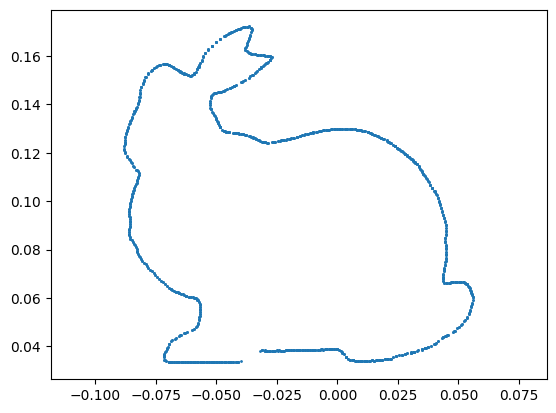

In [4]:
# Load the Stanford Bunny mesh
bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
# mesh = mesh.subdivide_midpoint(number_of_iterations=1)
mesh.compute_vertex_normals()

# Define the slicing plane (e.g., z = 0.05)
plane_origin = np.array([0, 0, 0])  # A point on the plane
plane_normal = np.array([0, 0, 1])    # Plane normal (z-direction)

# Compute the intersection points
slice_points = slice_mesh_with_plane(mesh, plane_origin, plane_normal)

# Convert the slice to a 2D point cloud (x, y)
points = np.asarray(slice_points)
point_cloud_2d = points[:, :2]  # Ignore z-coordinate for 2D

# visualize the 2D point cloud
plt.figure()
plt.scatter(point_cloud_2d[:, 0], point_cloud_2d[:, 1], s=1)
plt.axis('equal')
plt.show()

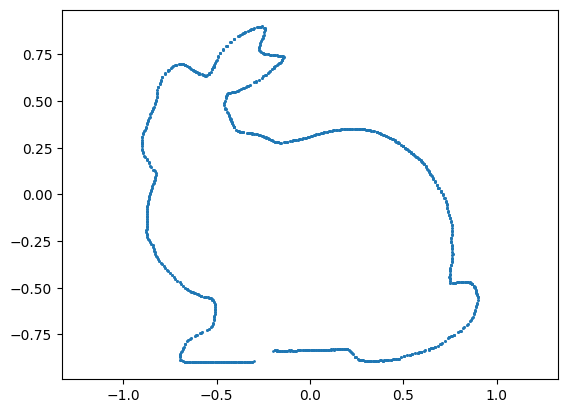

(1796, 2)


In [5]:
# Normalize the point cloud to [-1, 1]
pcl = point_cloud_2d
pcl = (pcl - pcl.min(axis=0)) / (pcl.max(axis=0) - pcl.min(axis=0))
pcl = 2 * pcl - 1
pcl = pcl * 0.9 # Scale the point cloud

# Visualize the normalized point cloud
plt.figure()
plt.scatter(pcl[:, 0], pcl[:, 1], s=1)
plt.axis('equal')
plt.show()

print(pcl.shape)


### Cholesky inverse version

In [138]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from scipy.linalg import cho_factor, cho_solve
from scipy.special import *

def generate_monomials(X, degree):
    """
    Generate monomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the point cloud.
        degree (int): The maximum degree of the monomials.

    Returns:
        ndarray: Monomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of monomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + (d-1) choose (d-1); (d-1) number of dividers for an array in space R^d.
    monomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        monomials[:, i] = np.prod(X ** exp, axis=1) # x1^exp1 * x2^exp2 * ... * xd^expd. e.g. x1^2 * x2^3 * x3^1 \in R^3
    return monomials

def generate_legendre_polynomials(X, degree):
    """
    Generate Legendre polynomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the polynomials.

    Returns:
        ndarray: Legendre polynomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of Legendre polynomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    legendre_polynomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        legendre_polynomials[:, i] = np.prod([legendre(exp[j])(X[:, j]) for j in range(d)], axis=0)
    return legendre_polynomials

def generate_chebyshev_polynomials(X, degree):
    """
    Generate Chebyshev polynomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the polynomials.

    Returns:
        ndarray: Chebyshev polynomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of Chebyshev polynomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    cheby_polynomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        cheby_polynomials[:, i] = np.prod([chebyt(exp[j])(X[:, j]) for j in range(d)], axis=0)
    return cheby_polynomials

def generate_db_wavelets(X, degree, wavelet_name="db2", level=10, domain=(-2, 2)):
    """
    Generate Daubechies wavelets up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the wavelets.
        wavelet_name (str): The name of the Daubechies wavelet.
        level (int): The level of the wavelet.
        
    Returns:
        ndarray: Daubechies wavelet matrix of shape (N, M).
    """
    N, d = X.shape
    
    wavelet = pywt.Wavelet(wavelet_name)
    phi, psi, x = wavelet.wavefun(level=level)
    
    # normalize x into domain
    psi = psi * ((x[-1] - x[0]) / (domain[1] - domain[0]))**0.5
    x = (x - x[0]) / (x[-1] - x[0]) * (domain[1] - domain[0]) + domain[0]
    
    def psi_jk(t, base_psi, base_x, j, k):
        scaled_shifted_arg = (2**j) * t - k 
        psi_values = np.interp(scaled_shifted_arg, base_x, base_psi, left=0, right=0)
        return (2.0**(j/2)) * psi_values
    
    jk_pairs = [(0, 0)]
    for j in range(1, degree + 1):
        jk_pairs.extend([(j, (1 + 2*k)) for k in range(j)])
        jk_pairs.extend([(j, -(1 + 2*k)) for k in range(j)])
    
    # Create a grid of the index over the d dimensional jk_pairs
    didx_jk_pairs = np.meshgrid(*[range(len(jk_pairs)) for _ in range(d)])
    didx_jk_pairs = np.stack([didx_jk.flatten() for didx_jk in didx_jk_pairs], axis=1)
        
    M = len(jk_pairs)**d
    print(f'Number of Daubechies wavelets: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    assert M == len(didx_jk_pairs)
    wavelets = np.ones((N, M))
    for i, didx in enumerate(didx_jk_pairs):
        wavelets[:, i] = np.prod([psi_jk(X[:, j], psi, x, *jk_pairs[didx[j]]) for j in range(d)], axis=0)
        
    return wavelets


def approximate_density(X, degree, poly=generate_monomials, grid_size=100, reg=1e-10, ax_lim=1.0):
    """
    Approximate the density on a grid using the Christoffel function.

    Parameters:
        X (ndarray): The original point cloud of shape (N, d).
        degree (int): The maximum degree of the polynomials.
        grid_size (int): The size of the grid for visualization.

    Returns:
        ndarray: Grid of x coordinates.
        ndarray: Grid of y coordinates.
        ndarray: Estimated density values on the grid.
    """
    N, d = X.shape
    # Generate polynomials at data points
    M_X = poly(X, degree)
    # plot each polynomial
    # for i in range(15):
    #     plt.figure()
    #     plt.scatter(X[:, 0], X[:, 1], c=M_X[:, i], cmap='hot')
    #     plt.colorbar()
    #     plt.title(f'P{i}')
    #     plt.show()
    
    # Compute empirical covariance matrix
    time_start = time.time()
    S = (M_X.T @ M_X) / N # (M x N) * (N x M) = M x M
    print(f'Time for covariance computation: {time.time() - time_start:.2f}s')
    print(S.min(), S.max())
    # Plot the covariance matrix
    plt.figure()
    plt.imshow(S, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Covariance matrix')
    plt.show()
    # Invert covariance matrix with regularization
    M = S.shape[0]
    
    # S_reg = S + reg * np.eye(M)
    # # Use Cholesky decomposition for numerical stability
    # time_start = time.time()
    # c, lower = cho_factor(S_reg)
    # print(f'Time for Cholesky decomposition: {time.time() - time_start:.2f}s')
    # time_start = time.time()
    # S_inv = cho_solve((c, lower), np.eye(M))
    # print(f'Time for Cholesky inverse computation: {time.time() - time_start:.2f}s')
    
    # Directly invert the covariance matrix
    time_start = time.time()
    S = S + reg * np.eye(M)
    S_inv = np.linalg.inv(S)
    plt.figure()
    plt.imshow(S_inv, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Covariance matrix')
    plt.show()
    print(f'Time for direct inverse computation: {time.time() - time_start:.2f}s')
    print(S_inv.min(), S_inv.max())
    
    # Create a grid over the domain
    # x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    # y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    # xx, yy = np.meshgrid(np.linspace(-ax_lim, ax_lim, grid_size),
    #                      np.linspace(-ax_lim, ax_lim, grid_size))
    # grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    r = [np.linspace(-ax_lim, ax_lim, grid_size) for _ in range(d)]
    grids =np.meshgrid(*r)
    grid_points = np.column_stack([grid.ravel() for grid in grids])
    # Compute monomials at grid points
    M_grid = poly(grid_points, degree)
    print(M_grid.shape, S_inv.shape)
    # Compute Christoffel function at grid points
    time_start = time.time()
    # kappas = np.einsum('ij,jk,ik->i', M_grid, S_inv, M_grid)
    kappas = np.sum(M_grid @ S_inv * M_grid, axis=1)
    print(f'Time for Christoffel function computation: {time.time() - time_start:.2f}s')
    print(f'Minimum Christoffel function value: {kappas.min()}')
    print(f'Maximum Christoffel function value: {kappas.max()}')
    # Compute density estimates
    densities = 1 / kappas
    # densities = kappas
    densities = densities.reshape((grid_size, grid_size))
    return grids, densities


Number of Daubechies wavelets: 169
Time for covariance computation: 0.00s
-0.5724969909490875 1.5720711115172046


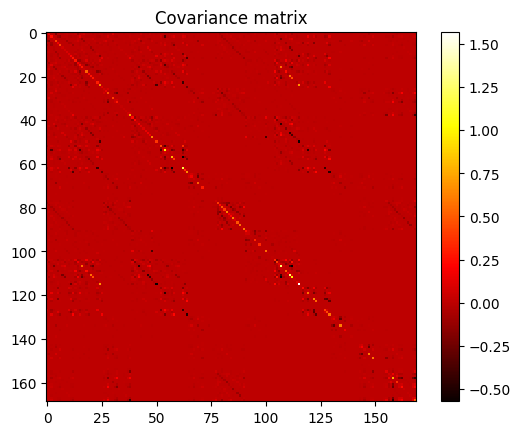

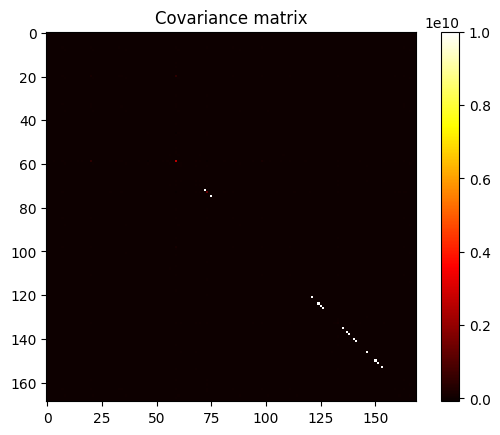

Time for direct inverse computation: 0.11s
-78568495.73827629 10000000000.0
Number of Daubechies wavelets: 169
(10000, 169) (169, 169)
Time for Christoffel function computation: 0.00s
Minimum Christoffel function value: 0.729023238281211
Maximum Christoffel function value: 3069548333585.134
1.3716983869508195 3.2578082874884466e-13


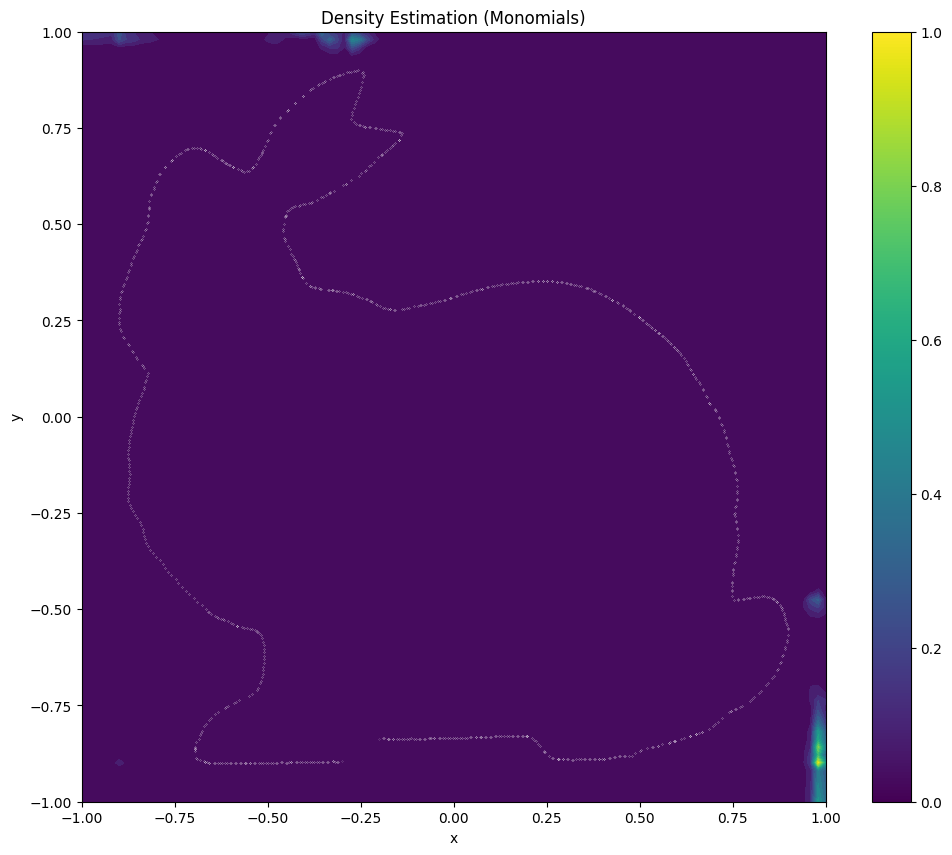

In [139]:
# Set the degree of polynomials
degree = 3
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_db_wavelets, grid_size=100, reg=1e-10)
print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(12,10))
plt.contourf(*grids, density, levels=20)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.colorbar()
plt.title('Density Estimation (Monomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Number of monomials: 91


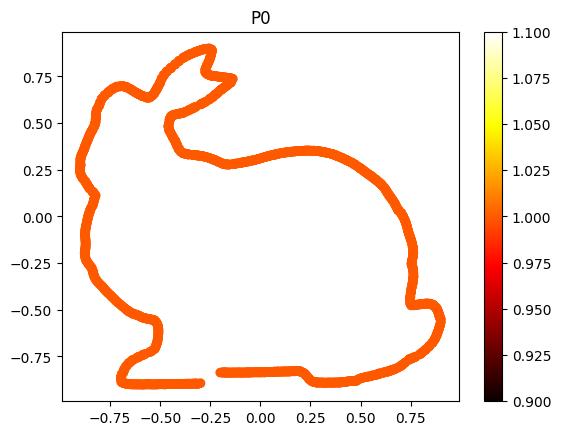

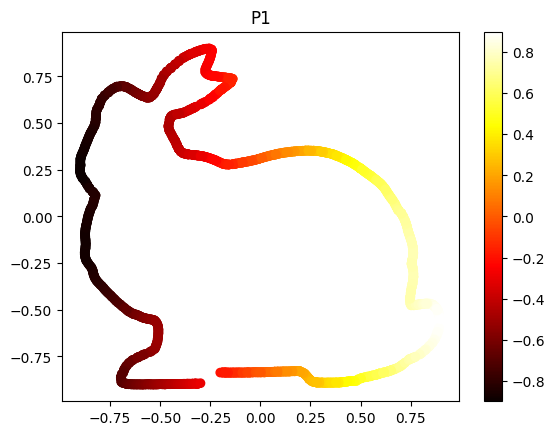

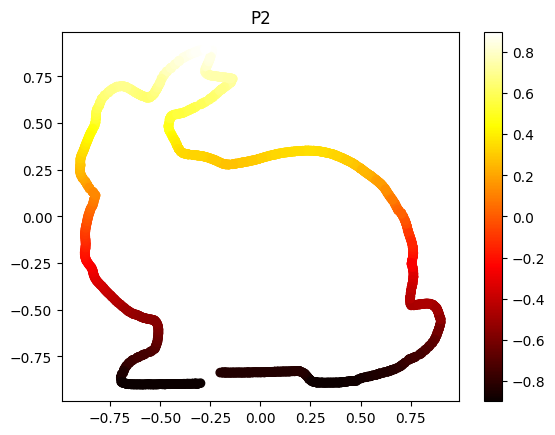

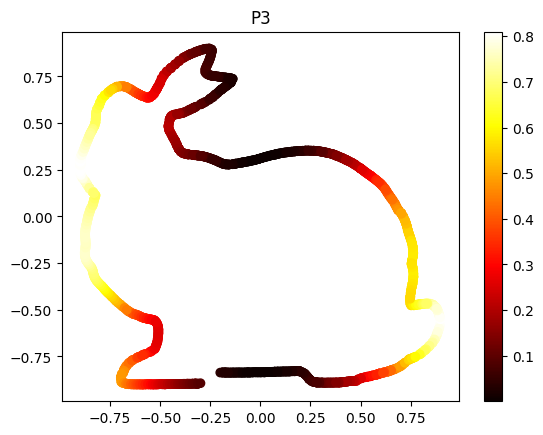

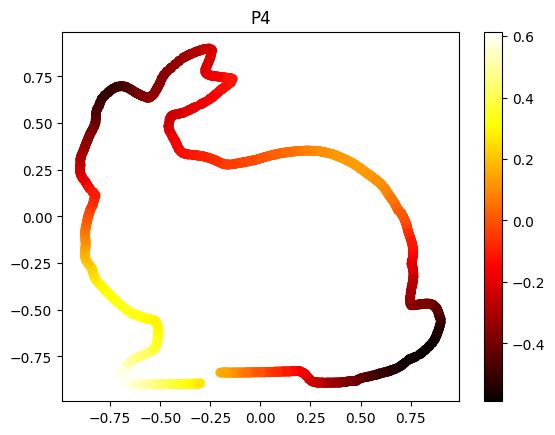

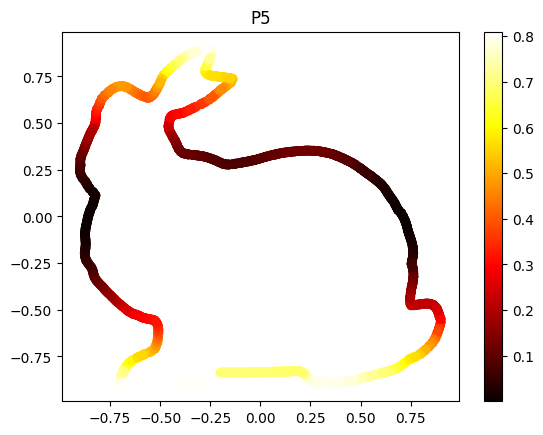

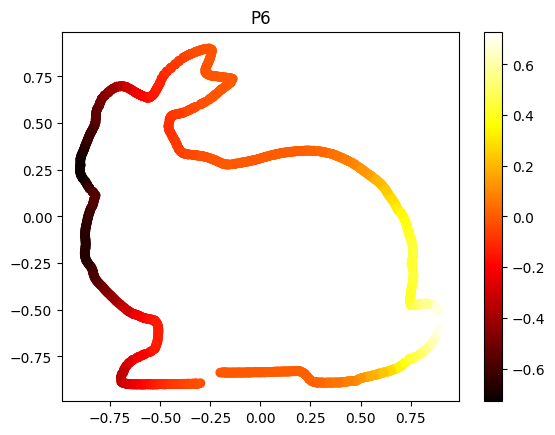

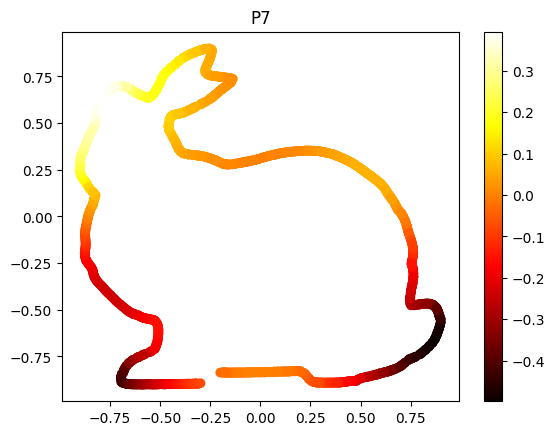

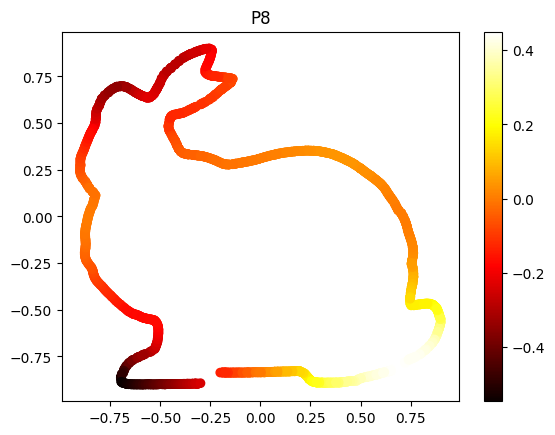

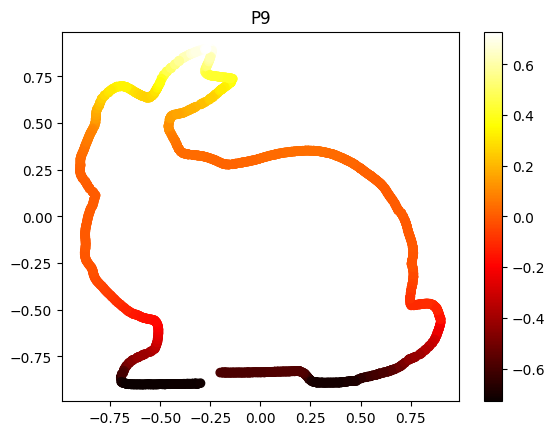

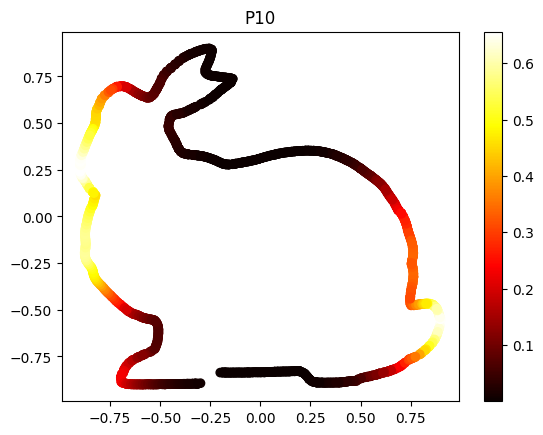

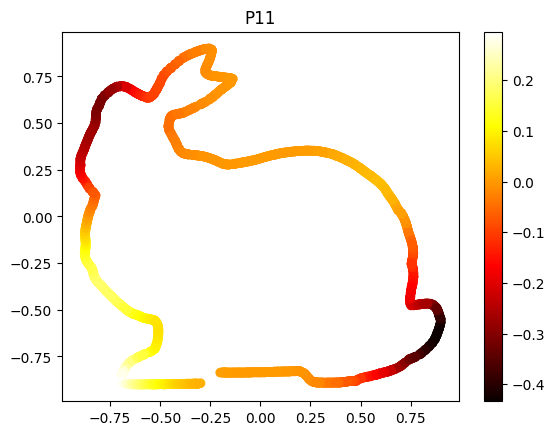

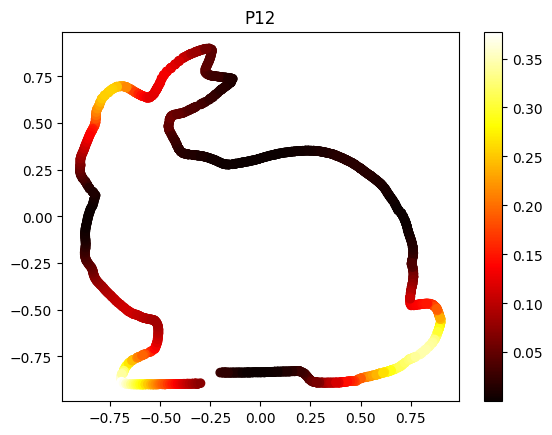

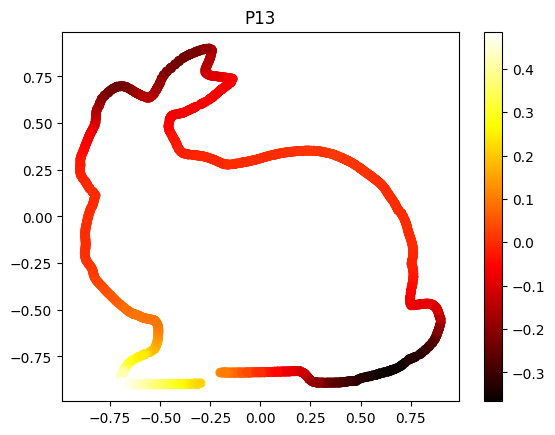

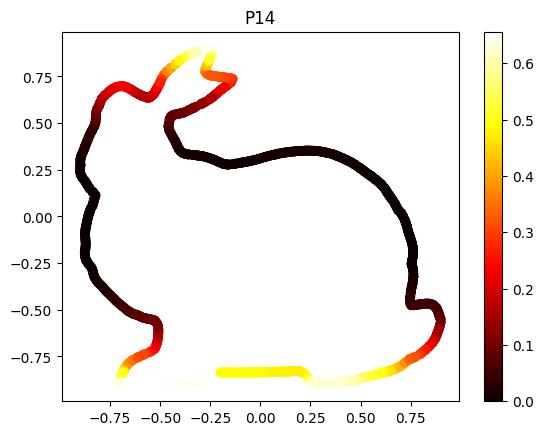

Time for covariance computation: 0.00s
-0.10576966517031308 1.0


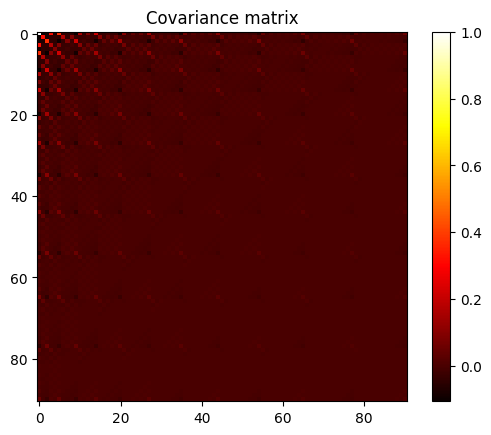

Time for direct inverse computation: 0.00s
-224113417495.22995 421905058215.9538
Number of monomials: 91
(1000000, 91) (91, 91)
Time for Christoffel function computation: 0.14s
Minimum Christoffel function value: 33.95622401684984
Maximum Christoffel function value: 24995863347231.566
0.029449682023059386 4.0006619739772086e-14


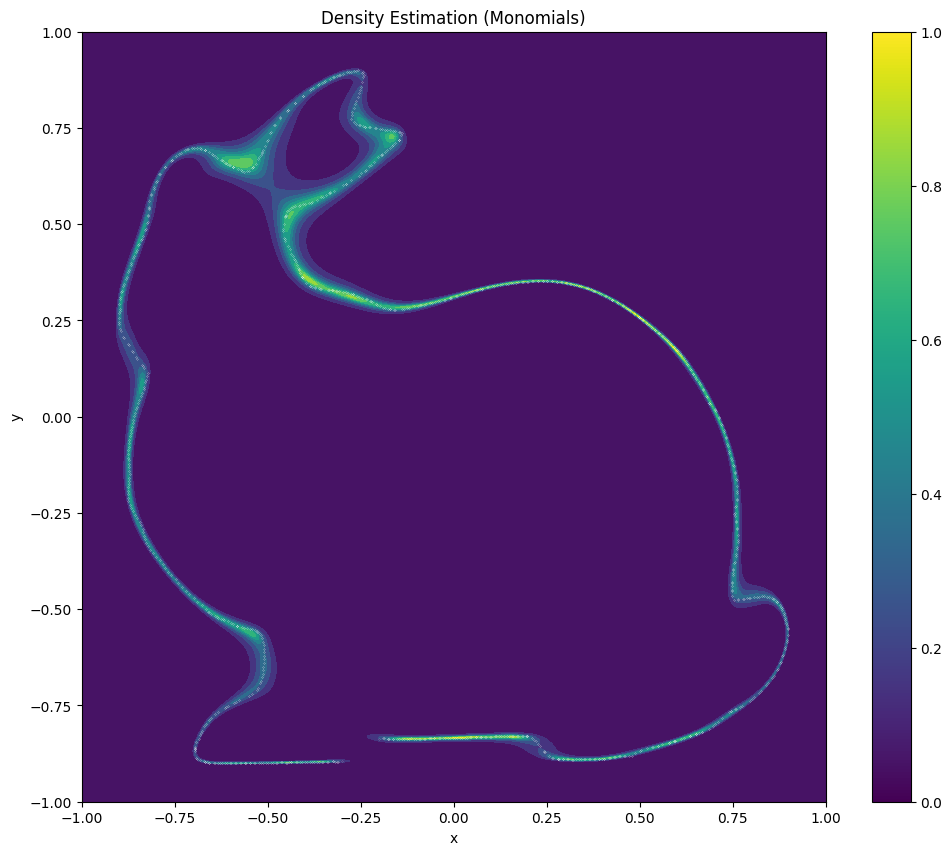

In [119]:
# Set the degree of polynomials
degree = 12
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_monomials, grid_size=1000, reg=1e-12)
print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(12,10))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.colorbar()
plt.title('Density Estimation (Monomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Number of Chebyshev polynomials: 136


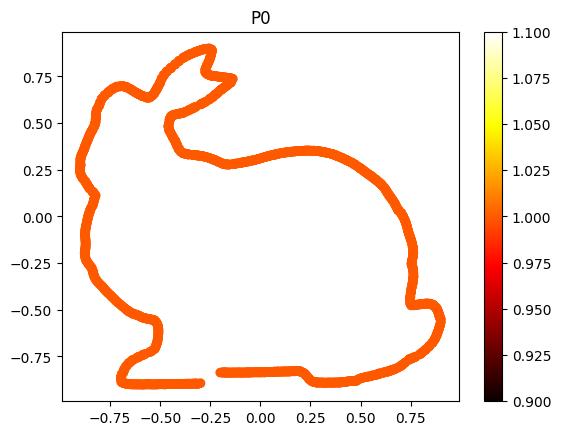

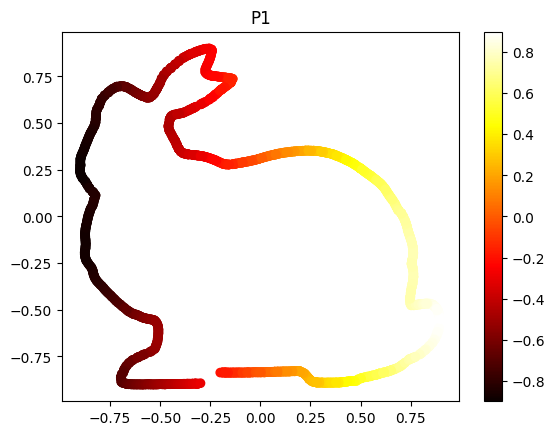

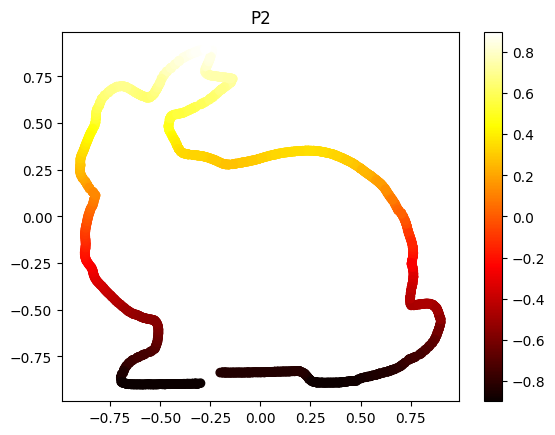

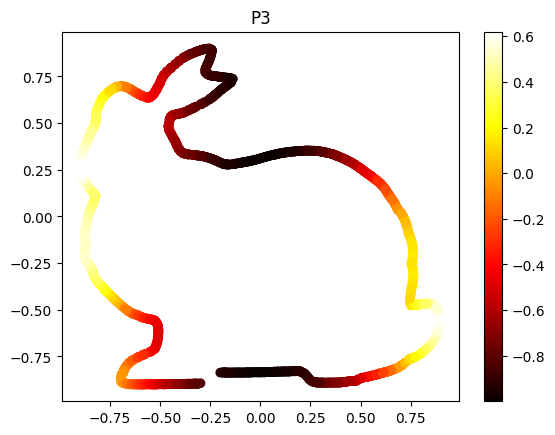

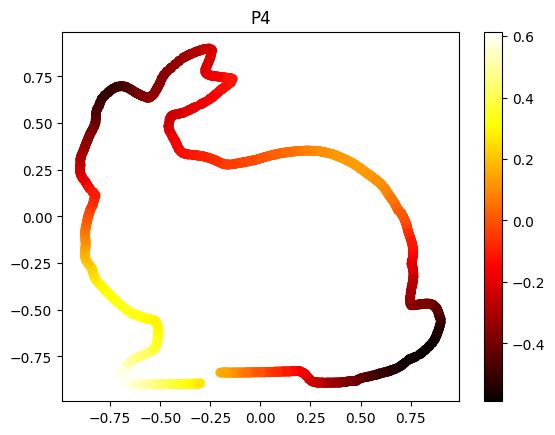

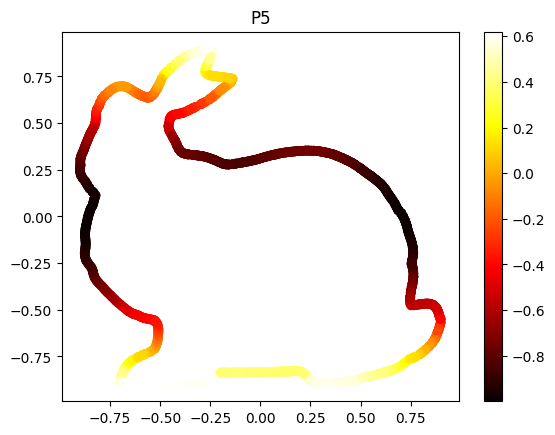

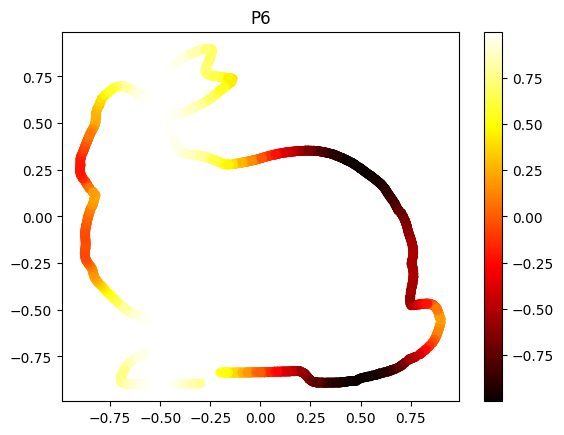

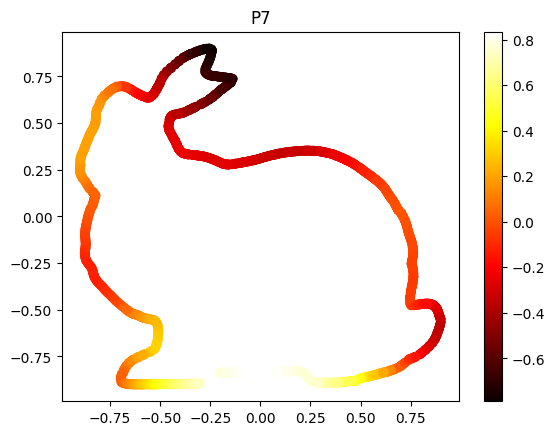

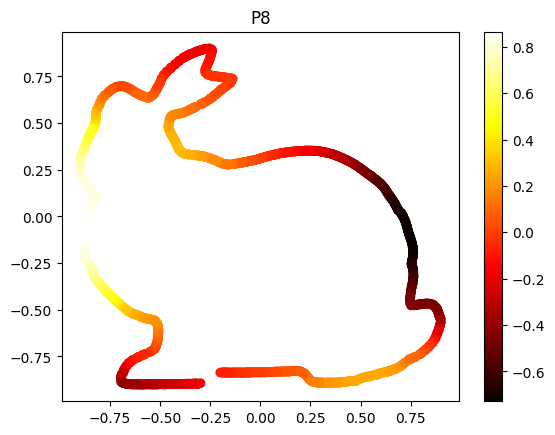

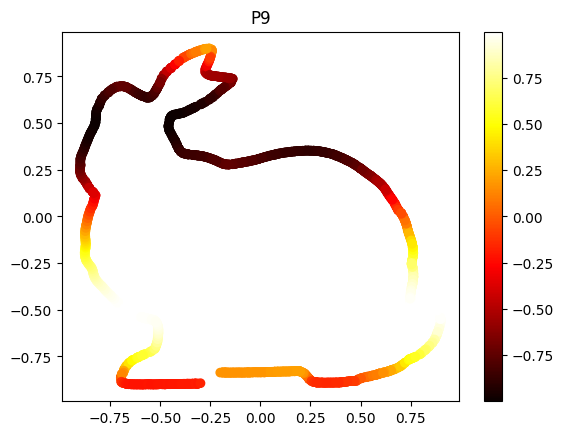

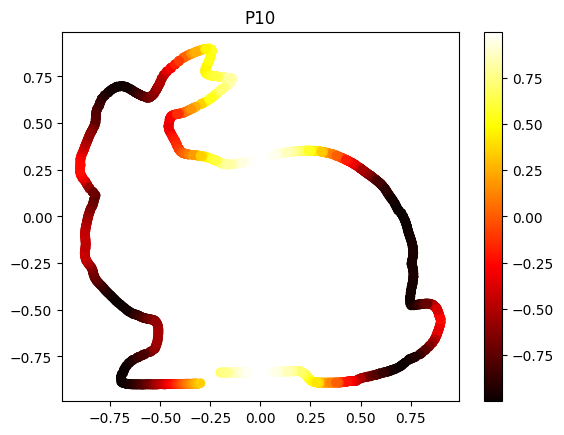

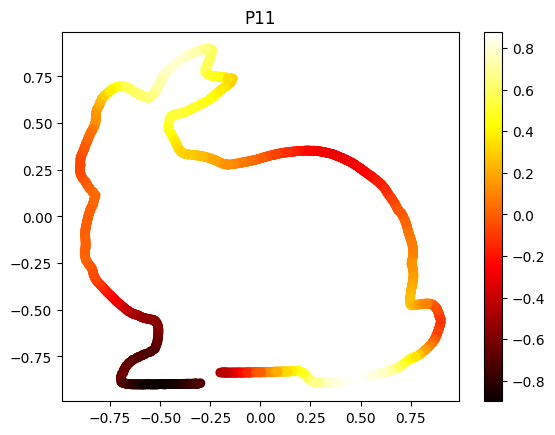

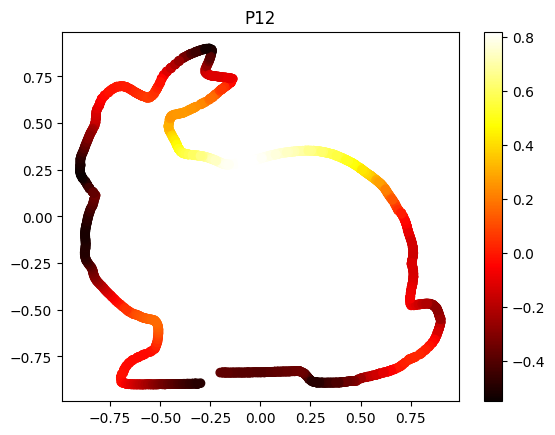

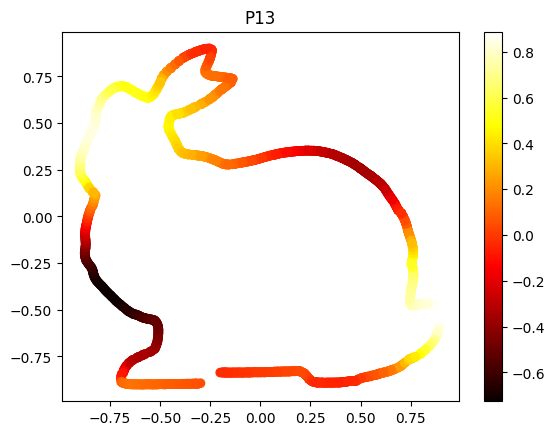

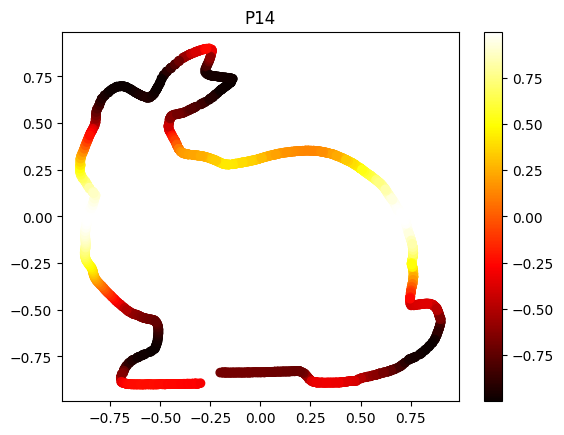

Time for covariance computation: 0.00s
-0.35921886104021883 1.0


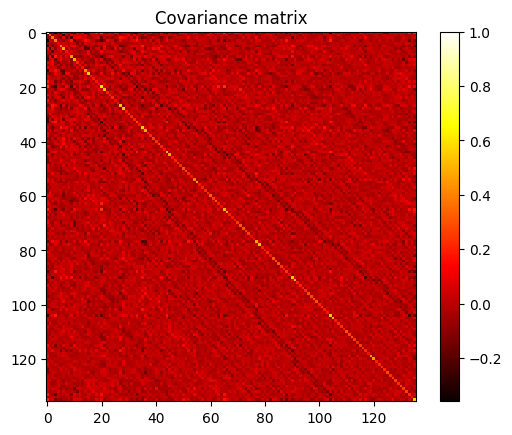

Time for direct inverse computation: 0.00s
-113762818967.58563 450334826705.5006
Number of Chebyshev polynomials: 136
(1000000, 136) (136, 136)
Time for Christoffel function computation: 0.21s
Minimum Christoffel function value: 46.69297158109839
Maximum Christoffel function value: 72506350302407.17


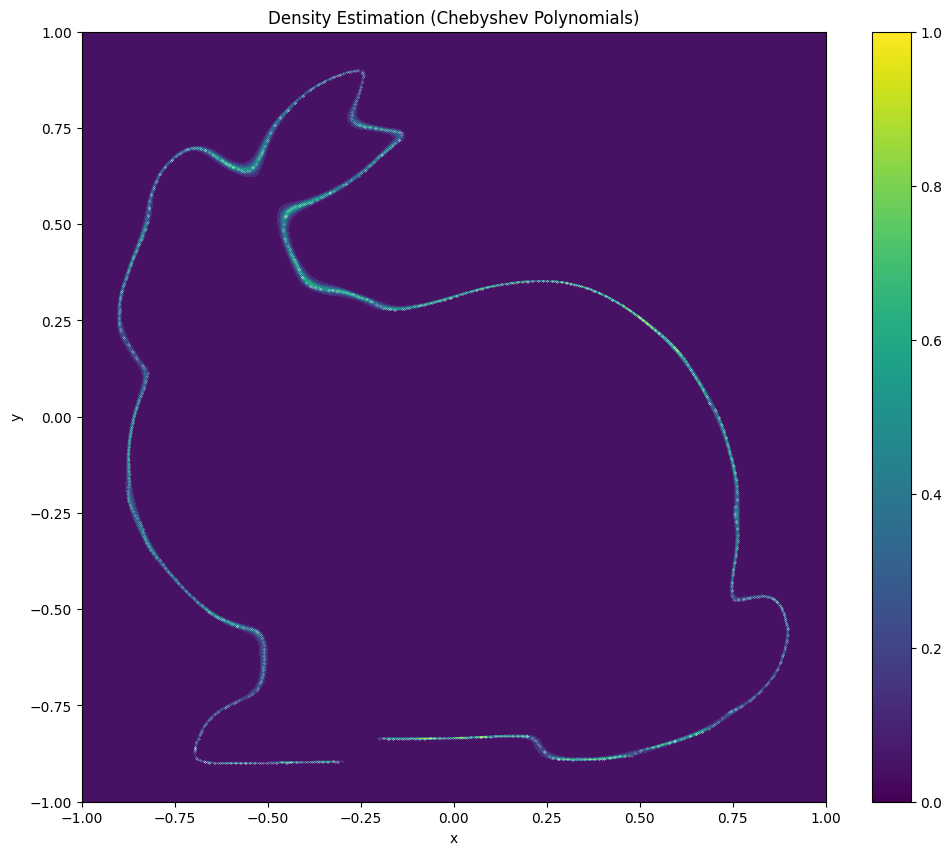

In [120]:
# Set the degree of polynomials
degree = 15
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_chebyshev_polynomials, grid_size=1000, reg=1e-12)
# print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(12,10))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.colorbar()
plt.title('Density Estimation (Chebyshev Polynomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Number of Legendre polynomials: 136


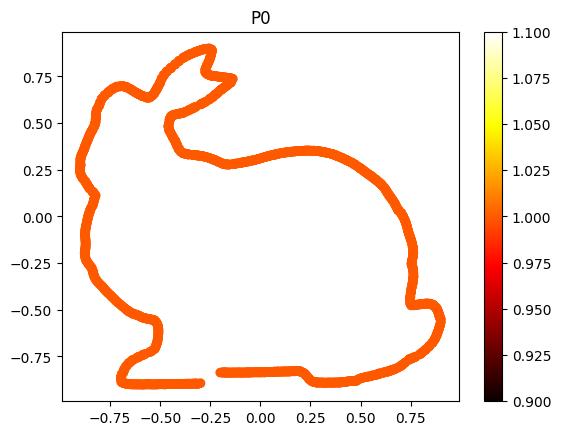

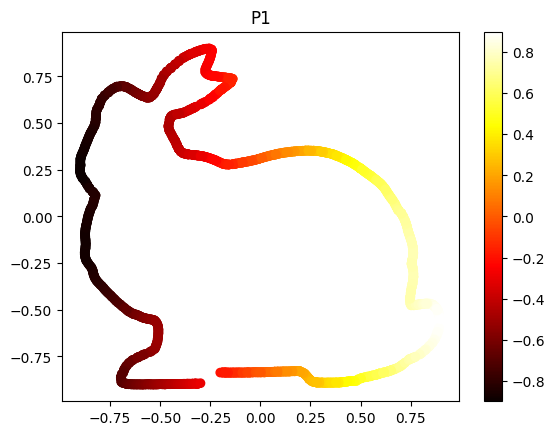

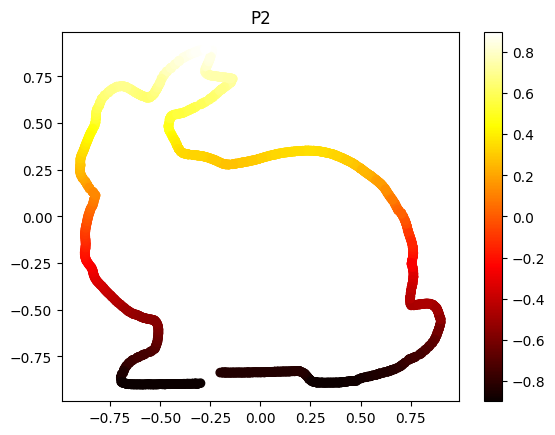

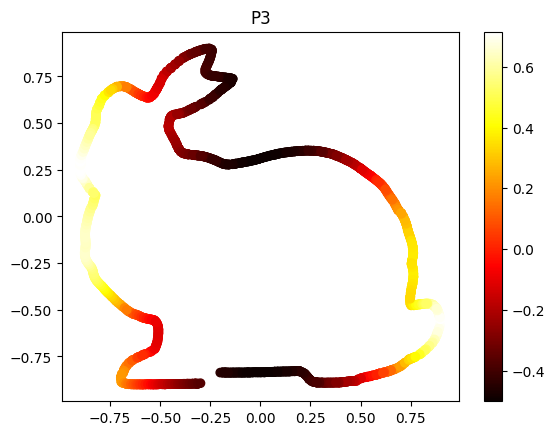

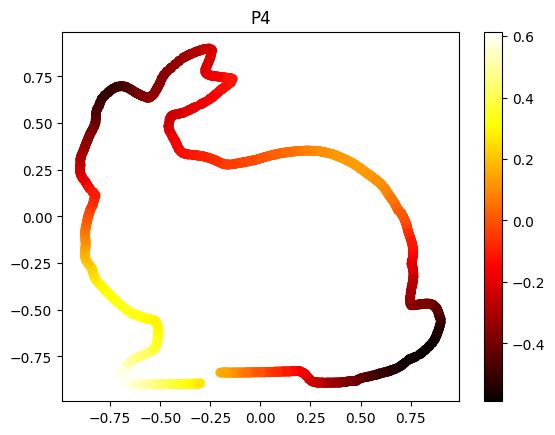

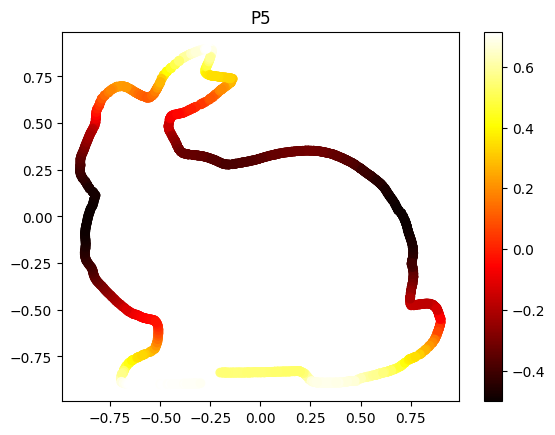

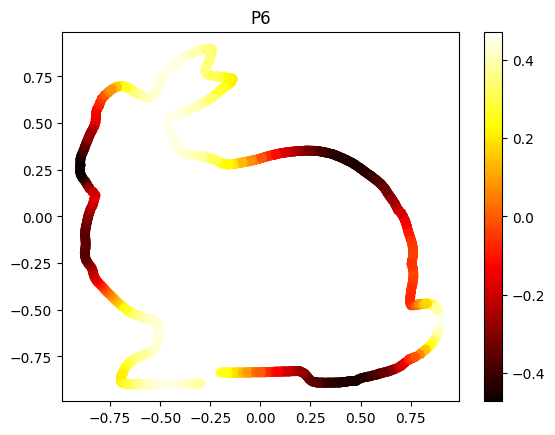

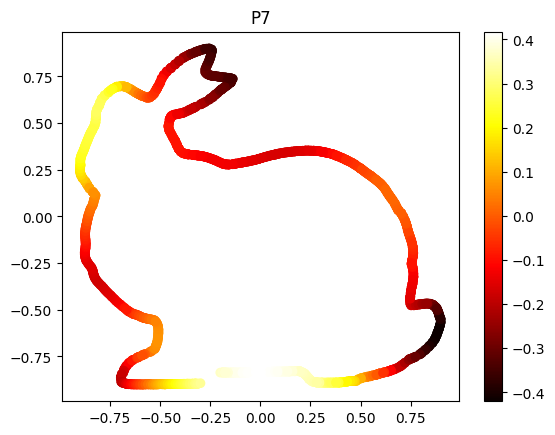

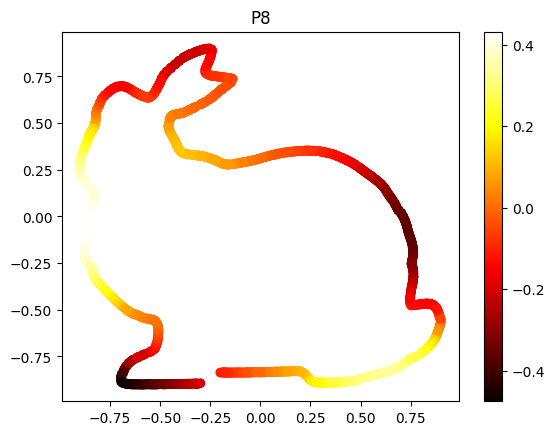

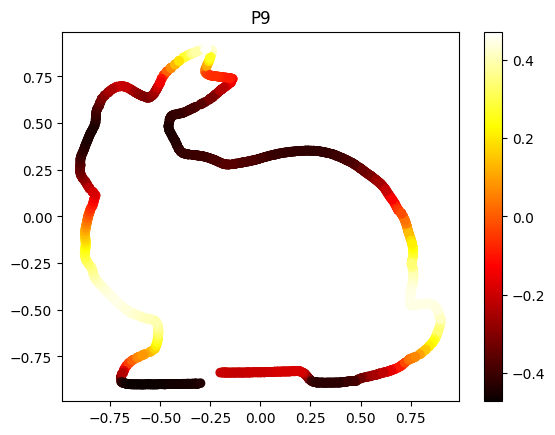

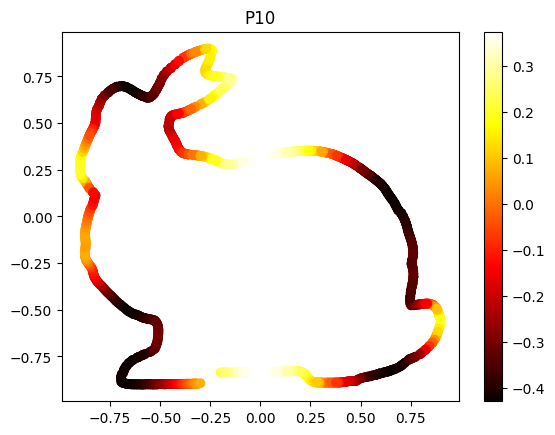

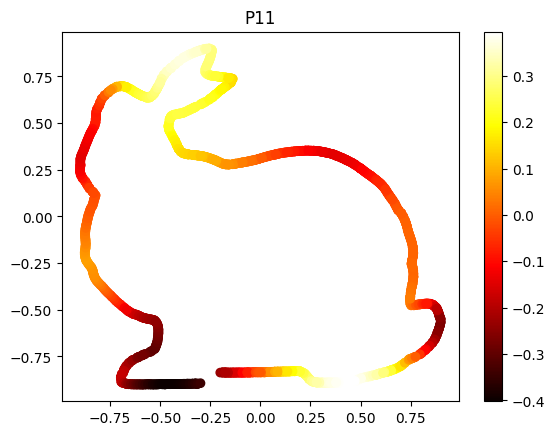

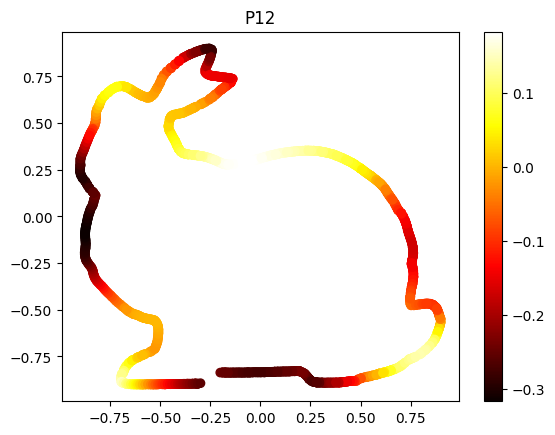

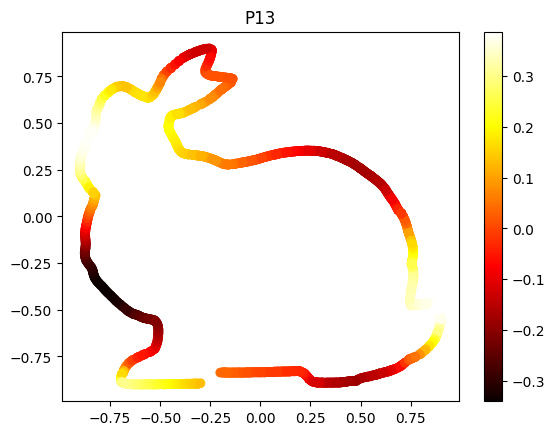

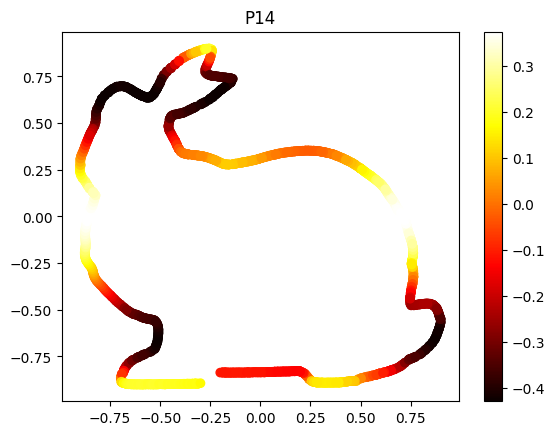

Time for covariance computation: 0.00s
-0.13351044369531792 1.0


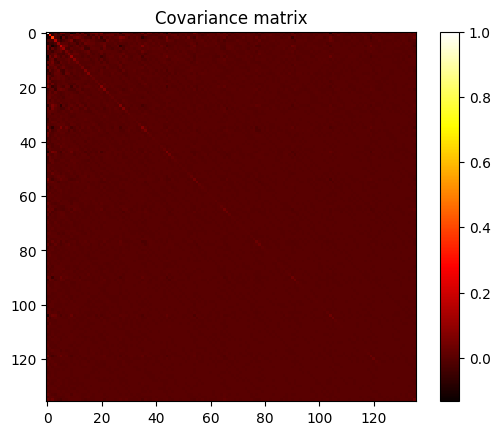

Time for direct inverse computation: 0.00s
-100830905097.77963 257464572811.76117
Number of Legendre polynomials: 136
(1000000, 136) (136, 136)
Time for Christoffel function computation: 0.23s
Minimum Christoffel function value: 46.069500342797255
Maximum Christoffel function value: 84970831917967.22


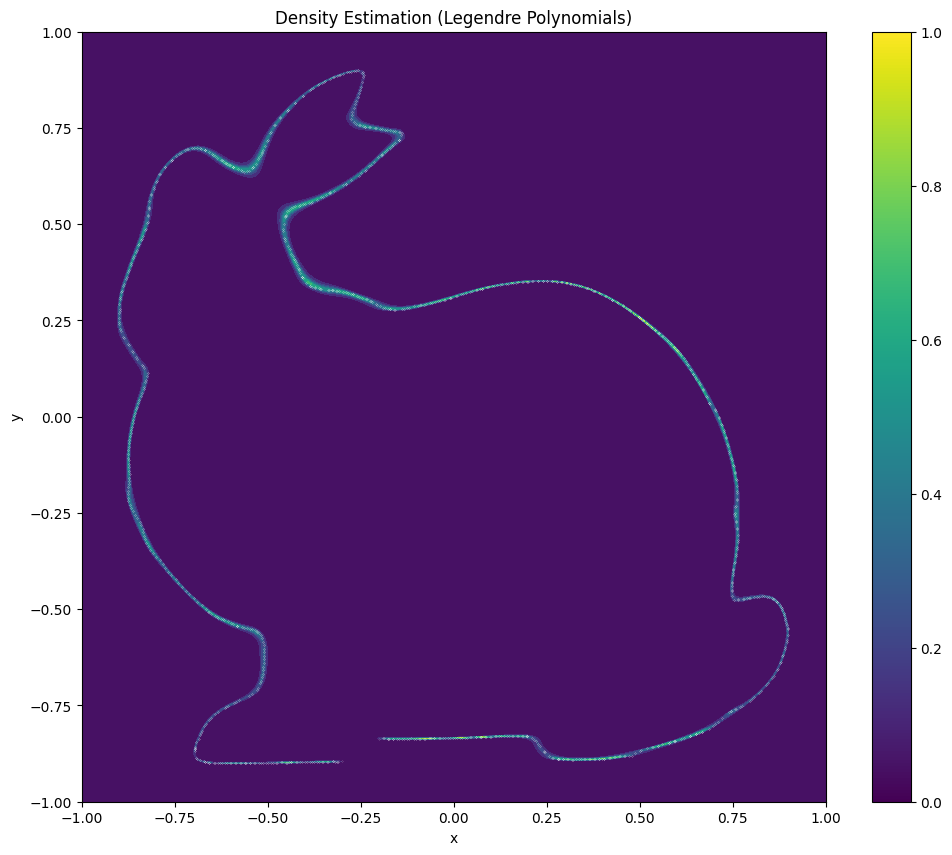

In [121]:
# Set the degree of polynomials
degree = 15
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_legendre_polynomials, grid_size=1000, reg=1e-12)
# print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(12,10))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.colorbar()
plt.title('Density Estimation (Legendre Polynomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()